## Glucocorticoid receptor - part 4 (library enumeration)

### Import libraries

In [1]:
import pandas as pd

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True, nb_workers=12)

import sys
sys.path.append('/home/daniel/wizepair2')
from mmpa.chem import strip_stereo
from mmpa.mmp import Reactor

from rdkit import Chem

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


### Read in the datasets

In [2]:
df = pd.read_csv('nr3c1_agonists_stripped.csv')
df_trans = pd.read_csv('nr3c1_agonists_transformations.csv')
df_holdout = pd.read_csv('nr3c1_agonists_stripped_holdout.csv')

### Take cortisol as only seed

In [3]:
#df = df[df.stripped_smiles=='CCCC1OC2CC3C4CCC5=CC(=O)C=CC5(C)C4C(O)CC3(C)C2(C(=O)O)O1']
#df = df[df.stripped_smiles=='C[C@]12C[C@H](O)[C@H]3[C@@H](CCC4=CC(=O)C=C[C@@]43C)[C@@H]1CC[C@]2(O)C(=O)O']
#df = df[df.stripped_smiles=='C[C@]12C[C@H](O)[C@H]3[C@@H](CCC4=CC(=O)C=C[C@@]43C)[C@@H]1CC[C@]2(O)C(=O)CO']
df = df[df.stripped_smiles=='C[C@]12C[C@H](O)[C@H]3[C@@H](CCC4=CC(=O)CC[C@@]43C)[C@@H]1CC[C@]2(O)C(=O)CO']

### Merge on assay identifier to enumerate all seed molecule / transformation pairs

In [4]:
#df = df[pd.notna(df.pchembl_value)]

In [5]:
df

,activity_properties,standard_units,standard_type,standard_relation,data_validity_comment,activity_comment,target_pref_name,bao_label,pchembl_value,assay_chembl_id,...,_metadata.assay_data.tissue_chembl_id,_metadata.assay_data.assay_parameters,_metadata.assay_data.assay_tissue,_metadata.source.src_description,ligand_efficiency.lle,ligand_efficiency.sei,ligand_efficiency.bei,ligand_efficiency.le,stripped_smiles,achiral_smiles
10,[],NaN,logFu,=,NaN,NaN,Plasma,cell-free format,NaN,CHEMBL1100461,...,CHEMBL3559721,[],Plasma,Scientific Literature,NaN,NaN,NaN,NaN,C[C@]12C[C@H](O)[C@H]3[C@@H](CCC4=CC(=O)CC[C@@...,CC12CCC(=O)C=C1CCC1C2C(O)CC2(C)C1CCC2(O)C(=O)CO
11,[],nM,IC50,>,NaN,NaN,Cytochrome P450 3A4,single protein format,NaN,CHEMBL664809,...,NaN,[],NaN,Scientific Literature,NaN,NaN,NaN,NaN,C[C@]12C[C@H](O)[C@H]3[C@@H](CCC4=CC(=O)CC[C@@...,CC12CCC(=O)C=C1CCC1C2C(O)CC2(C)C1CCC2(O)C(=O)CO
12,[],NaN,Ki,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,Cytochrome P450 1A2,cell-based format,NaN,CHEMBL1909132,...,NaN,[],NaN,DrugMatrix,NaN,NaN,NaN,NaN,C[C@]12C[C@H](O)[C@H]3[C@@H](CCC4=CC(=O)CC[C@@...,CC12CCC(=O)C=C1CCC1C2C(O)CC2(C)C1CCC2(O)C(=O)CO
13,[],NaN,IC50,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,Unchecked,cell membrane format,NaN,CHEMBL1909154,...,CHEMBL3559724,[],Cerebral cortex,DrugMatrix,NaN,NaN,NaN,NaN,C[C@]12C[C@H](O)[C@H]3[C@@H](CCC4=CC(=O)CC[C@@...,CC12CCC(=O)C=C1CCC1C2C(O)CC2(C)C1CCC2(O)C(=O)CO
14,[],NaN,Ki,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,Alpha-1a adrenergic receptor,cell membrane format,NaN,CHEMBL1909085,...,CHEMBL3987361,[],Submaxillary gland,DrugMatrix,NaN,NaN,NaN,NaN,C[C@]12C[C@H](O)[C@H]3[C@@H](CCC4=CC(=O)CC[C@@...,CC12CCC(=O)C=C1CCC1C2C(O)CC2(C)C1CCC2(O)C(=O)CO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2626,"[{'text_value': 'HEPATOCYTE, CENTRILOBULAR, HY...",NaN,Tissue Severity Score,NaN,NaN,See Activity_Supp For Individual Animal Data,Rattus norvegicus,organism-based format,NaN,CHEMBL3885882,...,NaN,"[{'comments': None, 'standard_units': None, 's...",NaN,DrugMatrix,NaN,NaN,NaN,NaN,C[C@]12C[C@H](O)[C@H]3[C@@H](CCC4=CC(=O)CC[C@@...,CC12CCC(=O)C=C1CCC1C2C(O)CC2(C)C1CCC2(O)C(=O)CO
2627,"[{'text_value': 'HEPATOCYTE, DIFFUSE, HYPERTRO...",NaN,Tissue Severity Score,NaN,NaN,See Activity_Supp For Individual Animal Data,Rattus norvegicus,organism-based format,NaN,CHEMBL3885882,...,NaN,"[{'comments': None, 'standard_units': None, 's...",NaN,DrugMatrix,NaN,NaN,NaN,NaN,C[C@]12C[C@H](O)[C@H]3[C@@H](CCC4=CC(=O)CC[C@@...,CC12CCC(=O)C=C1CCC1C2C(O)CC2(C)C1CCC2(O)C(=O)CO
2628,"[{'text_value': 'MALIGNANT LYMPHOMA', 'comment...",NaN,Tissue Severity Score,NaN,NaN,See Activity_Supp For Individual Animal Data,Rattus norvegicus,organism-based format,NaN,CHEMBL3885882,...,NaN,"[{'comments': None, 'standard_units': None, 's...",NaN,DrugMatrix,NaN,NaN,NaN,NaN,C[C@]12C[C@H](O)[C@H]3[C@@H](CCC4=CC(=O)CC[C@@...,CC12CCC(=O)C=C1CCC1C2C(O)CC2(C)C1CCC2(O)C(=O)CO
2629,[],%,Efficacy,=,NaN,NaN,Glucocorticoid receptor,cell-based format,NaN,CHEMBL4840202,...,NaN,[],Pancreas,Scientific Literature,NaN,NaN,NaN,NaN,C[C@]12C[C@H](O)[C@H]3[C@@H](CCC4=CC(=O)CC[C@@...,CC12CCC(=O)C=C1CCC1C2C(O)CC2(C)C1CCC2(O)C(=O)CO


### Apply the transformations

In [6]:
def enumerate_recursive(df: pd.DataFrame(), df_trans: pd.DataFrame(), generations=1, hits=None):
    
    if generations > 0: 
    
        # merge with transformations and enumerate products
        print('Generations {}: inital frame - {}'.format(generations, len(df.index)))
        df_unique = df[['stripped_smiles', 'target_pref_name', 'standard_type']].drop_duplicates()
        print('Generations {}: deduped seeds / property pairs - {}'.format(generations, len(df_unique.index)))
        df_unique = df_unique.merge(df_trans, on=['target_pref_name', 'standard_type'])
        print('Generations {}: potential seed / transformation pairs - {}'.format(generations, len(df_unique.index)))
        df_product = df_unique.sample(frac=1).parallel_apply(lambda x: Reactor(x.smirks).generate_products(x.stripped_smiles), axis=1)

        # fan out individual products
        df_product = df_unique.join(pd.DataFrame(df_product.explode(), columns=['products']))
        print('Generations {}: raw products - {}'.format(generations, len(df_product.index)))
        df_product = df_product[pd.notna(df_product.products)]
        print('Generations {}: non-null products - {}'.format(generations, len(df_product.index)))
        df_product = df.merge(df_product, on=['stripped_smiles', 'target_pref_name', 'standard_type'])
        print('Generations {}: final product / prediction pairs - {}'.format(generations, len(df_product.index)))

        # detect if target has been identified
        df_product['achiral_smiles'] = df_product.products.parallel_apply(strip_stereo)
        if df_product.achiral_smiles.isin(hits).any(): print('hit!')
                
        # trail tracking
        df_product['generation'] = generations
        if all(elem in df_product.columns for elem in ['last_smiles', 'min_pchembl_value', 'min_mean_percentmcs', 'max_radius']): 
            df_product.last_smiles = df_product.last_smiles + '.' + df_product.stripped_smiles
            df_product.min_pchembl_value = df_product[['min_pchembl_value', 'pchembl_value']].min(axis=1)
            df_product.min_mean_percentmcs = df_product[['min_mean_percentmcs', 'mean_percentmcs']].min(axis=1)
            df_product.max_radius = df_product[['max_radius', 'radius']].max(axis=1)
        else: 
            df_product['last_smiles'] = df_product.stripped_smiles
            df_product['min_pchembl_value'] = df_product.pchembl_value
            df_product['min_mean_percentmcs'] = df_product.mean_percentmcs
            df_product['max_radius'] = df_product.radius
            
        # update seed paramters
        df_product.stripped_smiles = df_product.products
        df_product.pchembl_value = df_product.pchembl_value + df_product.mean_pchembl_exact_delta
        
        # filter columns
        df_product = df_product[['generation', 'last_smiles', 'min_pchembl_value', 'min_mean_percentmcs', 'max_radius',
                                 'stripped_smiles', 'target_pref_name', 'standard_type', 'pchembl_value']]
        
        # filter rows
        df_product.drop_duplicates(inplace=True)

        # increment counter and yield
        generations -= 1
        yield df_product
        yield from enumerate_recursive(df_product, df_trans, generations, hits)


In [7]:
df_products = enumerate_recursive(df, df_trans, 2, df_holdout.achiral_smiles.unique())

In [8]:
df_products = pd.concat([x for x in df_products])

Generations 2: inital frame - 1378
Generations 2: deduped seeds / property pairs - 520
Generations 2: potential seed / transformation pairs - 2898


Generations 2: raw products - 3618
Generations 2: non-null products - 2166
Generations 2: final product / prediction pairs - 6042


Generations 1: inital frame - 2292
Generations 1: deduped seeds / property pairs - 1083
Generations 1: potential seed / transformation pairs - 8772


Generations 1: raw products - 9857
Generations 1: non-null products - 5806
Generations 1: final product / prediction pairs - 13048


hit!


In [9]:
df_combined = df_holdout.merge(df_products, on=['stripped_smiles', 'target_pref_name', 'standard_type'], suffixes=['_actual', '_predicted'])

In [10]:
pd.pivot_table(df_combined, 
               values=['pchembl_value_actual', 'pchembl_value_predicted', 'min_mean_percentmcs'], 
               index=['generation', 'max_radius', 'stripped_smiles', 'target_pref_name', 'standard_type'], 
               aggfunc=['min', 'mean', 'max'])

generation,max_radius,stripped_smiles,target_pref_name,standard_type


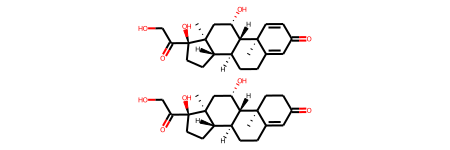

In [13]:
Chem.MolFromSmiles(df_products.sample(1).last_smiles.to_list()[0])

### Write to file

In [12]:
df_products = df_products.reset_index()
df_products.to_csv('nr3c1_agonists_products.csv', index=False)